# Song Lyrics vocabulary analysis and feature engineering

In this notebook, ill clean, visualize and analyze over 300,000 song lyrics data. With the goal of adding an NLP based features and using it as a database for context based language learning tool <br> I'll try to add new features as: vocabulary level, age district, lexical diversity and more.. 

In [41]:
import pandas as pd
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from better_profanity import profanity
import textstat
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

In [2]:
artists_df = pd.read_csv('artists-data.csv')
lyrics_df = pd.read_csv('lyrics-data.csv')

In [3]:
artists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4168 entries, 0 to 4167
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Artist      4167 non-null   object 
 1   Genres      4163 non-null   object 
 2   Songs       4167 non-null   float64
 3   Popularity  4166 non-null   float64
 4   Link        4167 non-null   object 
dtypes: float64(2), object(3)
memory usage: 162.9+ KB


In [4]:
lyrics_df.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


### I'll start with some EDA and data cleansing on the lyrics df

In [5]:
lyrics_df['language'].value_counts()

language
en     191814
pt     157393
es       9917
rw       1679
it       1432
fr       1225
de        844
fi        145
sv        112
ro         97
no         89
is         86
tl         69
pl         47
gl         36
ga         32
tr         32
id         26
cy         23
sw         19
af         19
su         19
ko         17
nl         14
ca         13
da         13
et         13
ms          8
ja          7
st          7
ht          5
eu          4
ar          4
ru          4
gd          4
ny          3
mg          3
ku          3
cs          3
lg          2
hu          2
jw          2
sq          1
lv          1
hr          1
zh          1
fa          1
vi          1
hmn         1
sr          1
iw          1
sl          1
Name: count, dtype: int64

I'll will keep only the languages: english, spanish, french, italian, portuguese and german as they have large enough lyrics and are an in demand languages

In [6]:
# Keep only few languages for analysis
lyrics_df = lyrics_df[lyrics_df['language'].isin(['en', 'pt', 'es', 'fr', 'it', 'de'])]

Let's change the language code to name to make it easier to read

In [7]:
# Create a dictionary mapping language codes to language names
language_map = {
    'en': 'English',
    'pt': 'Portuguese',
    'es': 'Spanish',
    'it': 'Italian',
    'fr': 'French',
    'de': 'German'
}

# Replace the language codes with language names
lyrics_df.loc[:, 'language'] = lyrics_df['language'].replace(language_map)

In [8]:
lyrics_df['language'].value_counts()

language
English       191814
Portuguese    157393
Spanish         9917
Italian         1432
French          1225
German           844
Name: count, dtype: int64

In [9]:
def summarize_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    missing_percent = missing_values / len(df) * 100
    missing_info = pd.DataFrame({
        'missing_values': missing_values,
        'missing_percent': missing_percent
    })
    return missing_info

In [10]:
missing_summary = summarize_missing_values(lyrics_df)
missing_summary

,missing_values,missing_percent
SName,2,0.000552


In [11]:
# Show the rows with missing values
lyrics_df[lyrics_df['SName'].isna()]

,ALink,SName,SLink,Lyric,language
163380,/motionless-in-white/,NaN,/motionless-in-white/c0de.html,Everything you know in the focus\nLive in the ...,English
196723,/blossoms/,NaN,/blossoms/blow.html,The cold road is all I know\nThe old road is w...,English


In [12]:
# Replace the NaN value with the correct song name
lyrics_df.loc[lyrics_df['SLink'] == '/blossoms/blow.html', 'SName'] = 'Blow'
lyrics_df.loc[lyrics_df['SLink'] == '/motionless-in-white/c0de.html', 'SName'] = 'c0de'

Let's Clean the lyrics a little bit..

In [13]:
# Delete \n from the lyrics
lyrics_df['Lyric'] = lyrics_df['Lyric'].str.replace('\n', ' ')

In [14]:
lyrics_df['Lyric']

0         Tudo o que eu quero nessa vida, Toda vida, é É...
1         Meu coração Sem direção Voando só por voar Sem...
2         É de babaixá! É de balacubaca! É de babaixá! É...
3         Quando a chuva passar  Pra quê falar Se você n...
4         A minha sorte grande foi você cair do céu Minh...
                                ...                        
379926    Chorus Here we stand waiting on the plain Dark...
379927    I nearly disappeared into the mouth of a croco...
379928    Amambuka, amambuka azothengisa izwe lakithi, i...
379929    Sweat in the heat for days on end waiting for ...
379930    Here we stand on the edge of the day Faces mel...
Name: Lyric, Length: 362625, dtype: object

In [15]:
# Remove the SLink column
lyrics_df = lyrics_df.drop(columns=['SLink'])

In [16]:
# Merge the artists_df and lyrics_df on the ALink and Link columns
merged_df = pd.merge(
    lyrics_df, 
    artists_df[['Artist', 'Link']], 
    left_on='ALink', 
    right_on='Link', 
    how='left'
)
merged_df = merged_df.drop(columns=['Link'])
merged_df = merged_df.drop(columns=['ALink'])

In [17]:
# Count rows with null artist
missing_summary = summarize_missing_values(merged_df)
missing_summary

,missing_values,missing_percent
Artist,891,0.245708


Seem like we have some missing artists names.. I'll replace those columns with 'unknown'

In [18]:
# Replace artists NaN values with 'Unknown'
merged_df['Artist'] = merged_df['Artist'].fillna('Unknown')

In [19]:
lyrics_df = merged_df
lyrics_df

,SName,Lyric,language,Artist
0,Arerê,"Tudo o que eu quero nessa vida, Toda vida, é É...",Portuguese,Ivete Sangalo
1,Se Eu Não Te Amasse Tanto Assim,Meu coração Sem direção Voando só por voar Sem...,Portuguese,Ivete Sangalo
2,Céu da Boca,É de babaixá! É de balacubaca! É de babaixá! É...,Portuguese,Ivete Sangalo
3,Quando A Chuva Passar,Quando a chuva passar Pra quê falar Se você n...,Portuguese,Ivete Sangalo
4,Sorte Grande,A minha sorte grande foi você cair do céu Minh...,Portuguese,Ivete Sangalo
...,...,...,...,...
362620,The Waiting,Chorus Here we stand waiting on the plain Dark...,English,Johnny Clegg
362621,Too Early For The Sky,I nearly disappeared into the mouth of a croco...,English,Johnny Clegg
362622,Warsaw 1943 (I Never Betrayed The Revolution),"Amambuka, amambuka azothengisa izwe lakithi, i...",English,Johnny Clegg
362623,When The System Has Fallen,Sweat in the heat for days on end waiting for ...,English,Johnny Clegg


In addition i'll concat a songs lyrics dataset in hebrew, that requires: <br>
1. clean the hebrew songs data
2. change the dataset features name so they'll match the lyrics dataset

### Clean the hebrew lyrics dataset

In [20]:
hebrew_lyrics = pd.read_csv('hebrew-songs.csv')
hebrew_lyrics

,artist,songs,song,artist_key,url,words count,unique words count
0,אדם,"['אחרי', 'שאמות', 'יבואו', 'פתאום', 'אנשים', '...",אחרי שאמות,Artist_Adam,http://shironet.mako.co.il/artist?type=lyrics&...,103,79
1,אדם,"['אתה', 'תראה', 'עוד', 'יגיעו', 'ימים', 'טובים...",אין יותר שדים,Artist_Adam,http://shironet.mako.co.il/artist?type=lyrics&...,117,85
2,אדם,"['משוטט', 'ברחוב', 'במתח', 'תר', 'בכל', 'חלון'...",אין מוצא,Artist_Adam,http://shironet.mako.co.il/artist?type=lyrics&...,67,47
3,אדם,"['איש', 'עוד', 'לא', 'הכיר', 'אותי', 'כמו', 'ש...",איש עוד לא הכיר אותי,Artist_Adam,http://shironet.mako.co.il/artist?type=lyrics&...,134,48
4,אדם,"['אנשים', 'טועים', 'בחושך', 'גשם', 'ניתך', 'הם...",אל תשכח,Artist_Adam,http://shironet.mako.co.il/artist?type=lyrics&...,135,61
...,...,...,...,...,...,...,...
14760,זוהר ארגוב,"['שם', 'הרחק', 'ביער', 'אלון', 'עתיק', 'ניצב',...",שיר הפרטיזן,Artist_Zohar_Argov,http://shironet.mako.co.il/artist?type=lyrics&...,122,79
14761,זוהר ארגוב,"['שרתי', 'בחיי', 'כבר', 'המון', 'שירים', 'כתבת...",שיר פרטי,Artist_Zohar_Argov,http://shironet.mako.co.il/artist?type=lyrics&...,93,76
14762,זוהר ארגוב,"['עמוק', 'עמוק', 'העצב', 'בעיניים', 'עמוק', 'ע...",שלכת,Artist_Zohar_Argov,http://shironet.mako.co.il/artist?type=lyrics&...,104,73
14763,זוהר ארגוב,"['אשיר', 'לך', 'שיר', 'עתיק', 'נושן', 'אשיר', ...",שני שושנים,Artist_Zohar_Argov,http://shironet.mako.co.il/artist?type=lyrics&...,99,61


In [21]:
# Edit the songs lyrics to remove the brackets and commas
hebrew_lyrics.iloc[:, hebrew_lyrics.columns.get_loc('songs')] = hebrew_lyrics.iloc[:, hebrew_lyrics.columns.get_loc('songs')].str.replace(r"[\[,'\]]", '', regex=True)

In [22]:
hebrew_lyrics

,artist,songs,song,artist_key,url,words count,unique words count
0,אדם,אחרי שאמות יבואו פתאום אנשים בלי בושה עם חיבוק...,אחרי שאמות,Artist_Adam,http://shironet.mako.co.il/artist?type=lyrics&...,103,79
1,אדם,אתה תראה עוד יגיעו ימים טובים הנשק ייתקרר לאט ...,אין יותר שדים,Artist_Adam,http://shironet.mako.co.il/artist?type=lyrics&...,117,85
2,אדם,משוטט ברחוב במתח תר בכל חלון נערות עומדות בפתח...,אין מוצא,Artist_Adam,http://shironet.mako.co.il/artist?type=lyrics&...,67,47
3,אדם,איש עוד לא הכיר אותי כמו שאת הכרת אותי לא הורי...,איש עוד לא הכיר אותי,Artist_Adam,http://shironet.mako.co.il/artist?type=lyrics&...,134,48
4,אדם,אנשים טועים בחושך גשם ניתך הם שותקים הם בודדים...,אל תשכח,Artist_Adam,http://shironet.mako.co.il/artist?type=lyrics&...,135,61
...,...,...,...,...,...,...,...
14760,זוהר ארגוב,שם הרחק ביער אלון עתיק ניצב לידו בדשא הפרטיזן ...,שיר הפרטיזן,Artist_Zohar_Argov,http://shironet.mako.co.il/artist?type=lyrics&...,122,79
14761,זוהר ארגוב,שרתי בחיי כבר המון שירים כתבתי מנגינות להרבה מ...,שיר פרטי,Artist_Zohar_Argov,http://shironet.mako.co.il/artist?type=lyrics&...,93,76
14762,זוהר ארגוב,עמוק עמוק העצב בעיניים עמוק עמוק היין במרתף הל...,שלכת,Artist_Zohar_Argov,http://shironet.mako.co.il/artist?type=lyrics&...,104,73
14763,זוהר ארגוב,אשיר לך שיר עתיק נושן אשיר לך זמר על שושן היה ...,שני שושנים,Artist_Zohar_Argov,http://shironet.mako.co.il/artist?type=lyrics&...,99,61


In [23]:
hebrew_lyrics['language'] = 'Hebrew'

In [24]:
# Drop the url column
hebrew_lyrics = hebrew_lyrics.drop(columns=['url'])

In [25]:
# Drop the artist_key column as it is not needed
hebrew_lyrics = hebrew_lyrics.drop(columns=['artist_key'])

### Adding some features to the lyrics dataset  

In [26]:
def count_words_and_unique(text):
    tokenizer = RegexpTokenizer(r"\b\w+(?:'\w+)?\b")
    words = tokenizer.tokenize(text.lower())
    total_words = len(words)
    unique_words = len(set(words))
    return total_words, unique_words

In [27]:
lyrics_df['words count'], lyrics_df['unique words count'] = zip(*lyrics_df['Lyric'].map(count_words_and_unique))

In [28]:
lyrics_df

,SName,Lyric,language,Artist,words count,unique words count
0,Arerê,"Tudo o que eu quero nessa vida, Toda vida, é É...",Portuguese,Ivete Sangalo,88,48
1,Se Eu Não Te Amasse Tanto Assim,Meu coração Sem direção Voando só por voar Sem...,Portuguese,Ivete Sangalo,140,68
2,Céu da Boca,É de babaixá! É de balacubaca! É de babaixá! É...,Portuguese,Ivete Sangalo,122,26
3,Quando A Chuva Passar,Quando a chuva passar Pra quê falar Se você n...,Portuguese,Ivete Sangalo,158,75
4,Sorte Grande,A minha sorte grande foi você cair do céu Minh...,Portuguese,Ivete Sangalo,190,61
...,...,...,...,...,...,...
362620,The Waiting,Chorus Here we stand waiting on the plain Dark...,English,Johnny Clegg,198,100
362621,Too Early For The Sky,I nearly disappeared into the mouth of a croco...,English,Johnny Clegg,137,72
362622,Warsaw 1943 (I Never Betrayed The Revolution),"Amambuka, amambuka azothengisa izwe lakithi, i...",English,Johnny Clegg,221,136
362623,When The System Has Fallen,Sweat in the heat for days on end waiting for ...,English,Johnny Clegg,260,140


Before concat the hebrew dataset to it, lets match its feature names and order.

In [29]:
# Change the hebrew_lyrics columns names to match the lyrics_df columns names
hebrew_lyrics.columns = ['Artist', 'Lyric', 'SName', 'words count', 'unique words count', 'language']
# Change the order of the columns
hebrew_lyrics = hebrew_lyrics[['SName', 'Lyric','language', 'Artist', 'words count', 'unique words count']]
hebrew_lyrics

,SName,Lyric,language,Artist,words count,unique words count
0,אחרי שאמות,אחרי שאמות יבואו פתאום אנשים בלי בושה עם חיבוק...,Hebrew,אדם,103,79
1,אין יותר שדים,אתה תראה עוד יגיעו ימים טובים הנשק ייתקרר לאט ...,Hebrew,אדם,117,85
2,אין מוצא,משוטט ברחוב במתח תר בכל חלון נערות עומדות בפתח...,Hebrew,אדם,67,47
3,איש עוד לא הכיר אותי,איש עוד לא הכיר אותי כמו שאת הכרת אותי לא הורי...,Hebrew,אדם,134,48
4,אל תשכח,אנשים טועים בחושך גשם ניתך הם שותקים הם בודדים...,Hebrew,אדם,135,61
...,...,...,...,...,...,...
14760,שיר הפרטיזן,שם הרחק ביער אלון עתיק ניצב לידו בדשא הפרטיזן ...,Hebrew,זוהר ארגוב,122,79
14761,שיר פרטי,שרתי בחיי כבר המון שירים כתבתי מנגינות להרבה מ...,Hebrew,זוהר ארגוב,93,76
14762,שלכת,עמוק עמוק העצב בעיניים עמוק עמוק היין במרתף הל...,Hebrew,זוהר ארגוב,104,73
14763,שני שושנים,אשיר לך שיר עתיק נושן אשיר לך זמר על שושן היה ...,Hebrew,זוהר ארגוב,99,61


### Finally lets concat them :)

In [30]:
# Concatenate the two DataFrames
lyrics_df = pd.concat([lyrics_df, hebrew_lyrics])
lyrics_df

,SName,Lyric,language,Artist,words count,unique words count
0,Arerê,"Tudo o que eu quero nessa vida, Toda vida, é É...",Portuguese,Ivete Sangalo,88,48
1,Se Eu Não Te Amasse Tanto Assim,Meu coração Sem direção Voando só por voar Sem...,Portuguese,Ivete Sangalo,140,68
2,Céu da Boca,É de babaixá! É de balacubaca! É de babaixá! É...,Portuguese,Ivete Sangalo,122,26
3,Quando A Chuva Passar,Quando a chuva passar Pra quê falar Se você n...,Portuguese,Ivete Sangalo,158,75
4,Sorte Grande,A minha sorte grande foi você cair do céu Minh...,Portuguese,Ivete Sangalo,190,61
...,...,...,...,...,...,...
14760,שיר הפרטיזן,שם הרחק ביער אלון עתיק ניצב לידו בדשא הפרטיזן ...,Hebrew,זוהר ארגוב,122,79
14761,שיר פרטי,שרתי בחיי כבר המון שירים כתבתי מנגינות להרבה מ...,Hebrew,זוהר ארגוב,93,76
14762,שלכת,עמוק עמוק העצב בעיניים עמוק עמוק היין במרתף הל...,Hebrew,זוהר ארגוב,104,73
14763,שני שושנים,אשיר לך שיר עתיק נושן אשיר לך זמר על שושן היה ...,Hebrew,זוהר ארגוב,99,61


In [31]:
# Remove songs which contains less than 13 words as they are less useful and may contain gibberish
lyrics_df = lyrics_df[lyrics_df['words count'] > 12]
# Remove songs which contains more than 1000 words as they are less useful and may contain gibberish
lyrics_df = lyrics_df[lyrics_df['words count'] < 1001]

In [32]:
# Show the number of songs per language
songs_per_language = lyrics_df['language'].value_counts()
songs_per_language

language
English       190856
Portuguese    157169
Hebrew         14509
Spanish         9886
Italian         1429
French          1219
German           838
Name: count, dtype: int64

In [61]:
# Define unique colors for each language 
color_scheme = {
    'English': '#1f77b4',  # Blue
    'Spanish': '#ff7f0e',  # Orange
    'French': '#2ca02c',   # Green
    'German': '#d62728',   # Red
    'Italian': '#9467bd',  # Purple
    'Portuguese': '#8c564b',  # Brown
    'Hebrew' : '#e377c2'  # Pink
}

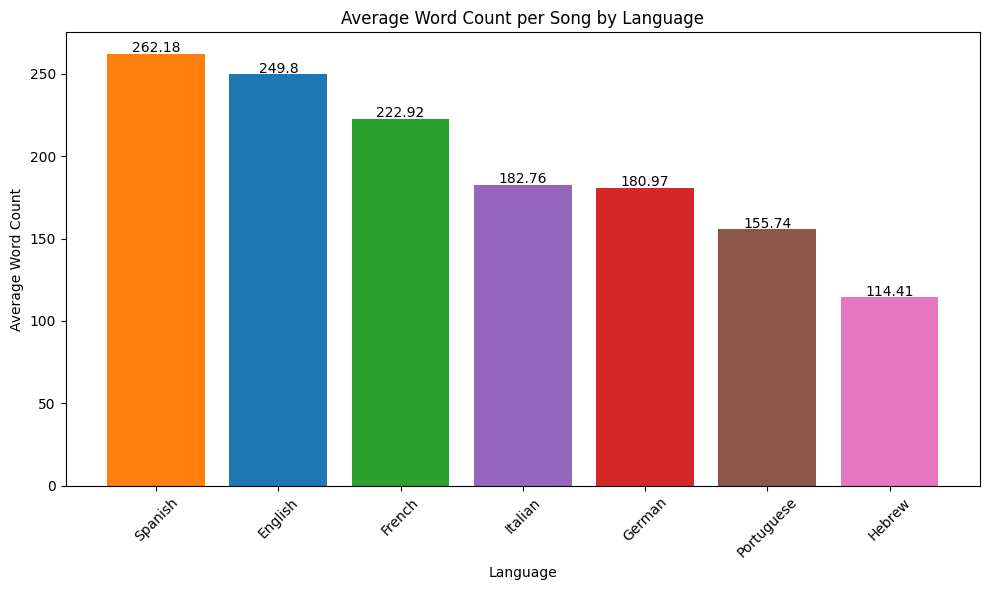

In [60]:
word_count_by_language = lyrics_df.groupby('language')['words count'].mean().round(2).reset_index()
word_count_by_language = word_count_by_language.sort_values('words count', ascending=False)

# Define colors (if you have a specific color scheme for each language)
colors = [color_scheme[lang] if lang in color_scheme else 'gray' for lang in word_count_by_language['language']]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(word_count_by_language['language'], word_count_by_language['words count'], color=colors)

# Add labels and title
plt.xlabel('Language')
plt.ylabel('Average Word Count')
plt.title('Average Word Count per Song by Language')

# Display values on top of bars
for i, value in enumerate(word_count_by_language['words count']):
    plt.text(i, value + 1, str(value), ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

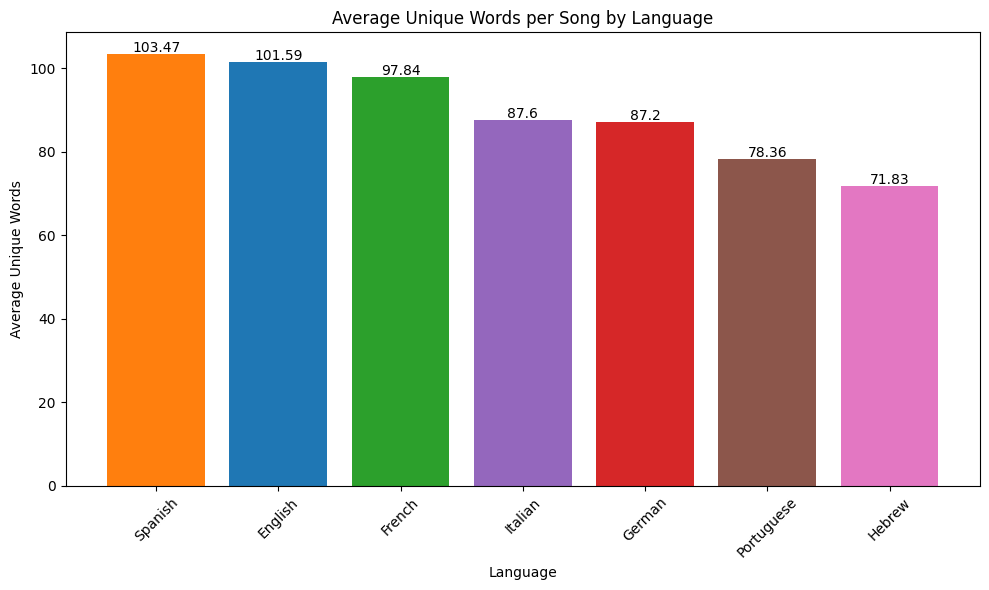

In [62]:
# Calculate the average unique words count per language and sort
avg_unique_words = lyrics_df.groupby('language')['unique words count'].mean().round(2).reset_index()
avg_unique_words = avg_unique_words.sort_values('unique words count', ascending=False)

# Define colors for each language if you have a color scheme
colors = [color_scheme[lang] if lang in color_scheme else 'gray' for lang in avg_unique_words['language']]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(avg_unique_words['language'], avg_unique_words['unique words count'], color=colors)

# Add labels and title
plt.xlabel('Language')
plt.ylabel('Average Unique Words')
plt.title('Average Unique Words per Song by Language')

# Display values on top of bars
for i, value in enumerate(avg_unique_words['unique words count']):
    plt.text(i, value + 0.5, str(value), ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


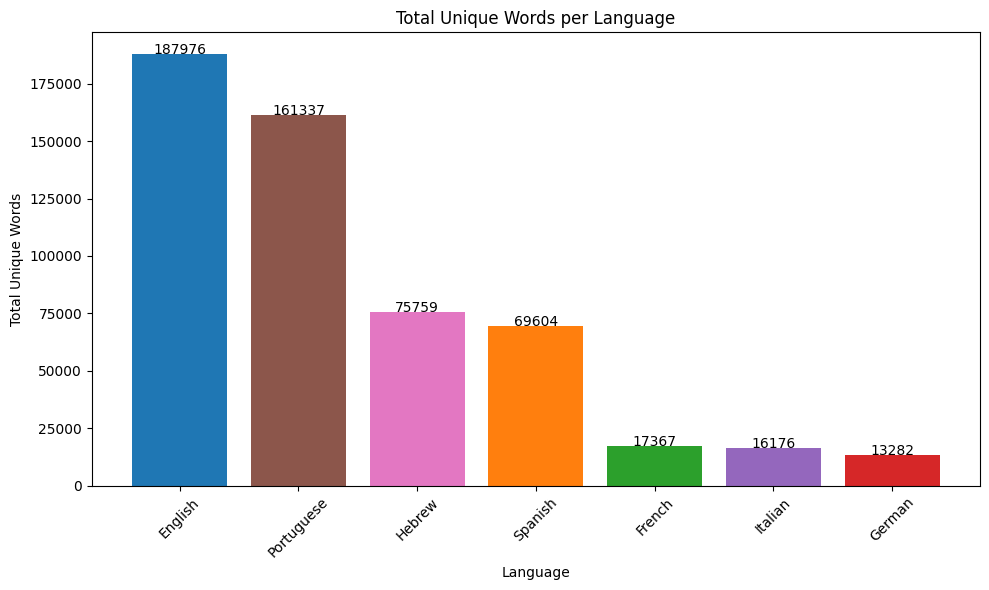

In [66]:
# Initialize defaultdict to store unique words per language
language_words = defaultdict(set)

# Iterate through the dataframe to collect unique words for each language
for index, row in lyrics_df.iterrows():
    tokenizer = RegexpTokenizer(r'\b\w+\b')
    words = tokenizer.tokenize(row['Lyric'].lower())  # Tokenize the words in the
    language_words[row['language']].update(words)  # Add unique words to the language set

# Calculate the total number of unique words for each language
total_unique_words = {lang: len(words) for lang, words in language_words.items()}

# Convert to a DataFrame for plotting
total_unique_words_df = pd.DataFrame(list(total_unique_words.items()), columns=['language', 'unique words count'])
total_unique_words_df = total_unique_words_df.sort_values('unique words count', ascending=False)

colors = [color_scheme[lang] if lang in color_scheme else 'gray' for lang in total_unique_words_df['language']]

# Plot with Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(total_unique_words_df['language'], total_unique_words_df['unique words count'], color=colors)

# Add labels and title
plt.xlabel('Language')
plt.ylabel('Total Unique Words')
plt.title('Total Unique Words per Language')

# Display values on top of bars
for i, value in enumerate(total_unique_words_df['unique words count']):
    plt.text(i, value + 0.5, str(value), ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analyzing words frequency per language - english, portuguese, spanish and french

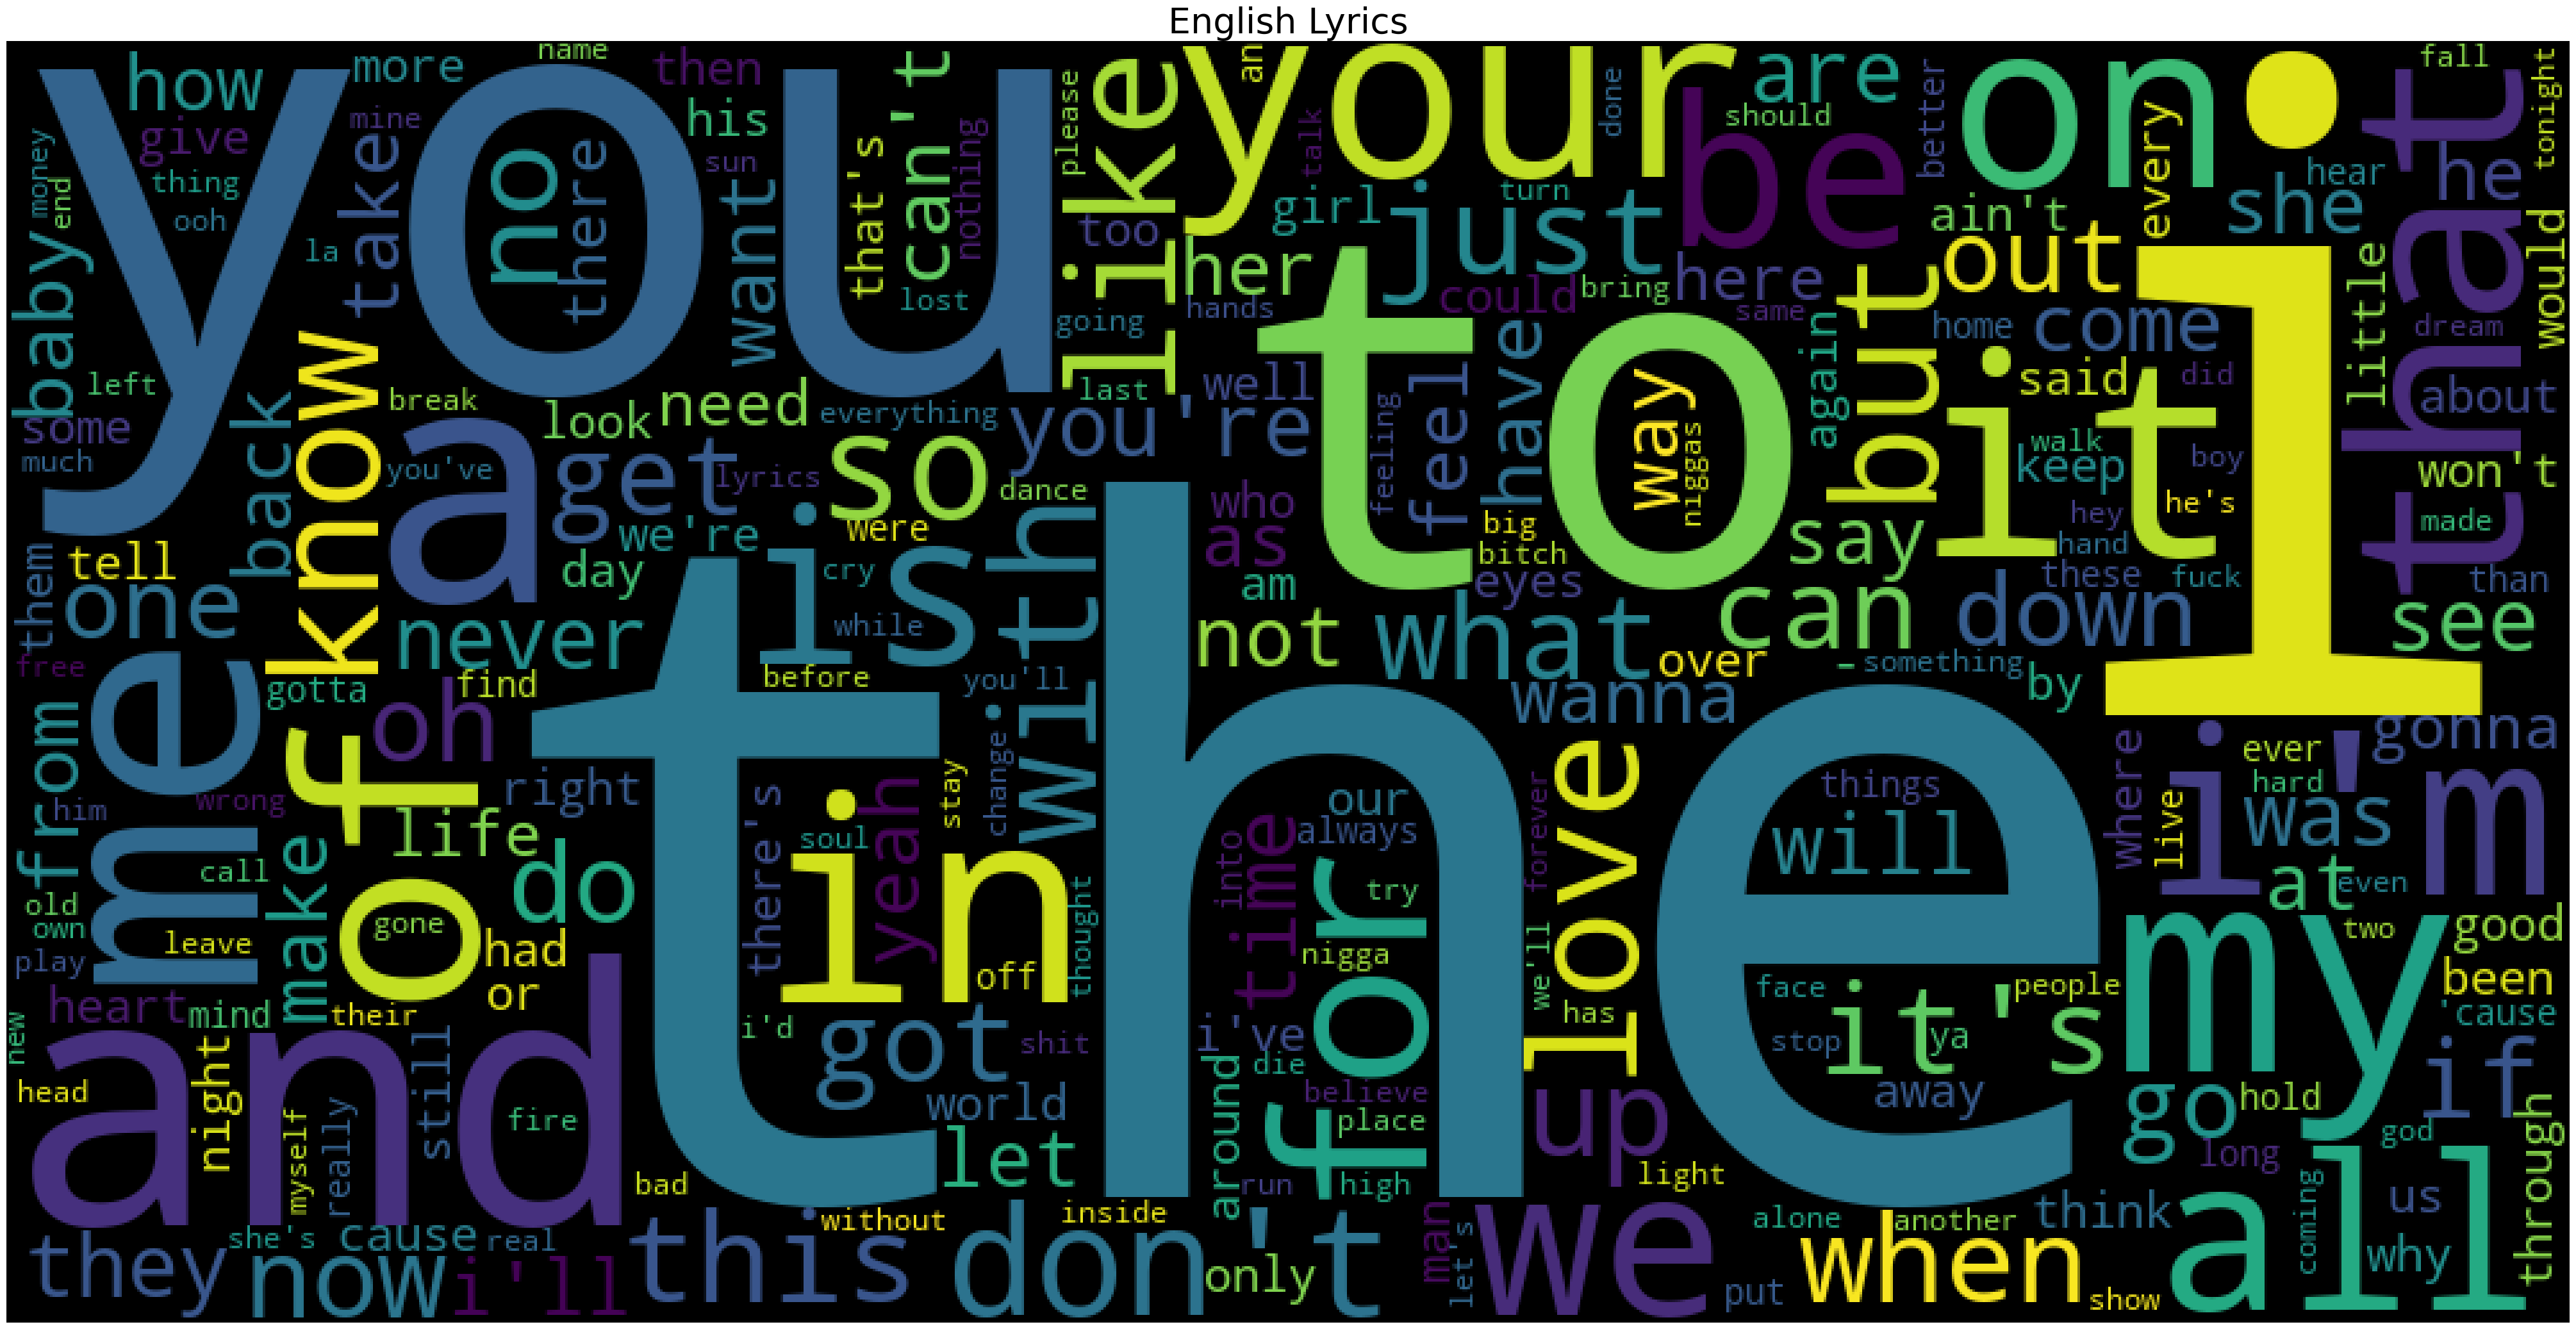

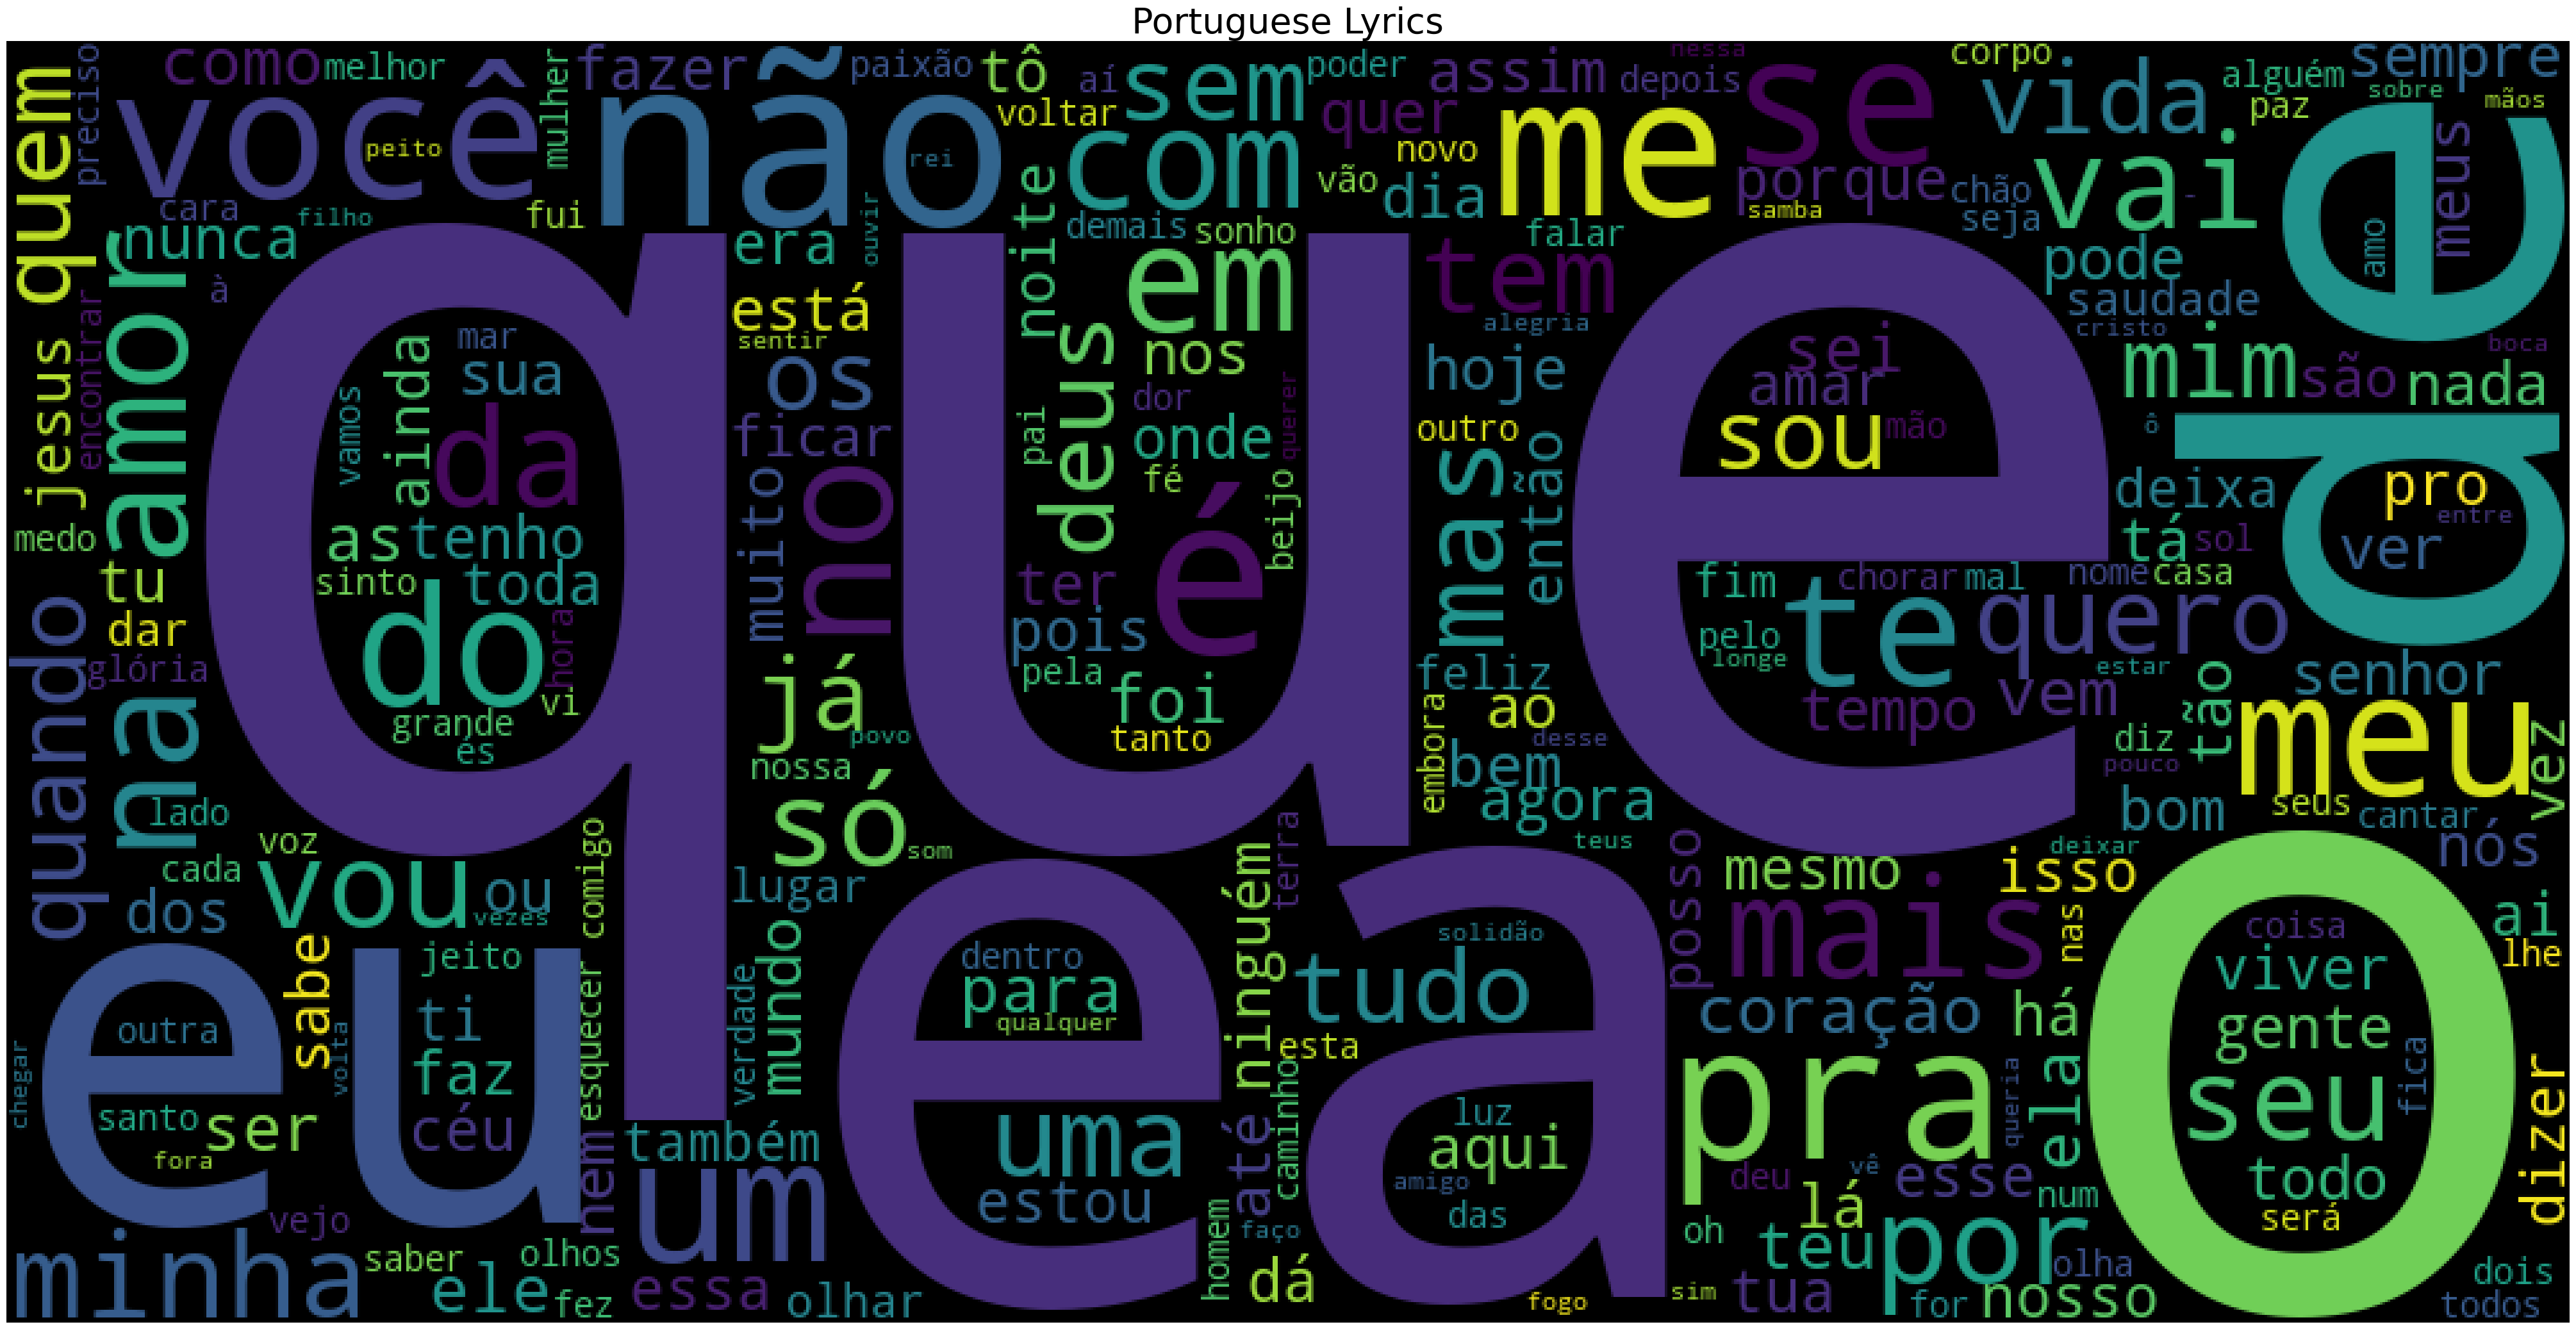

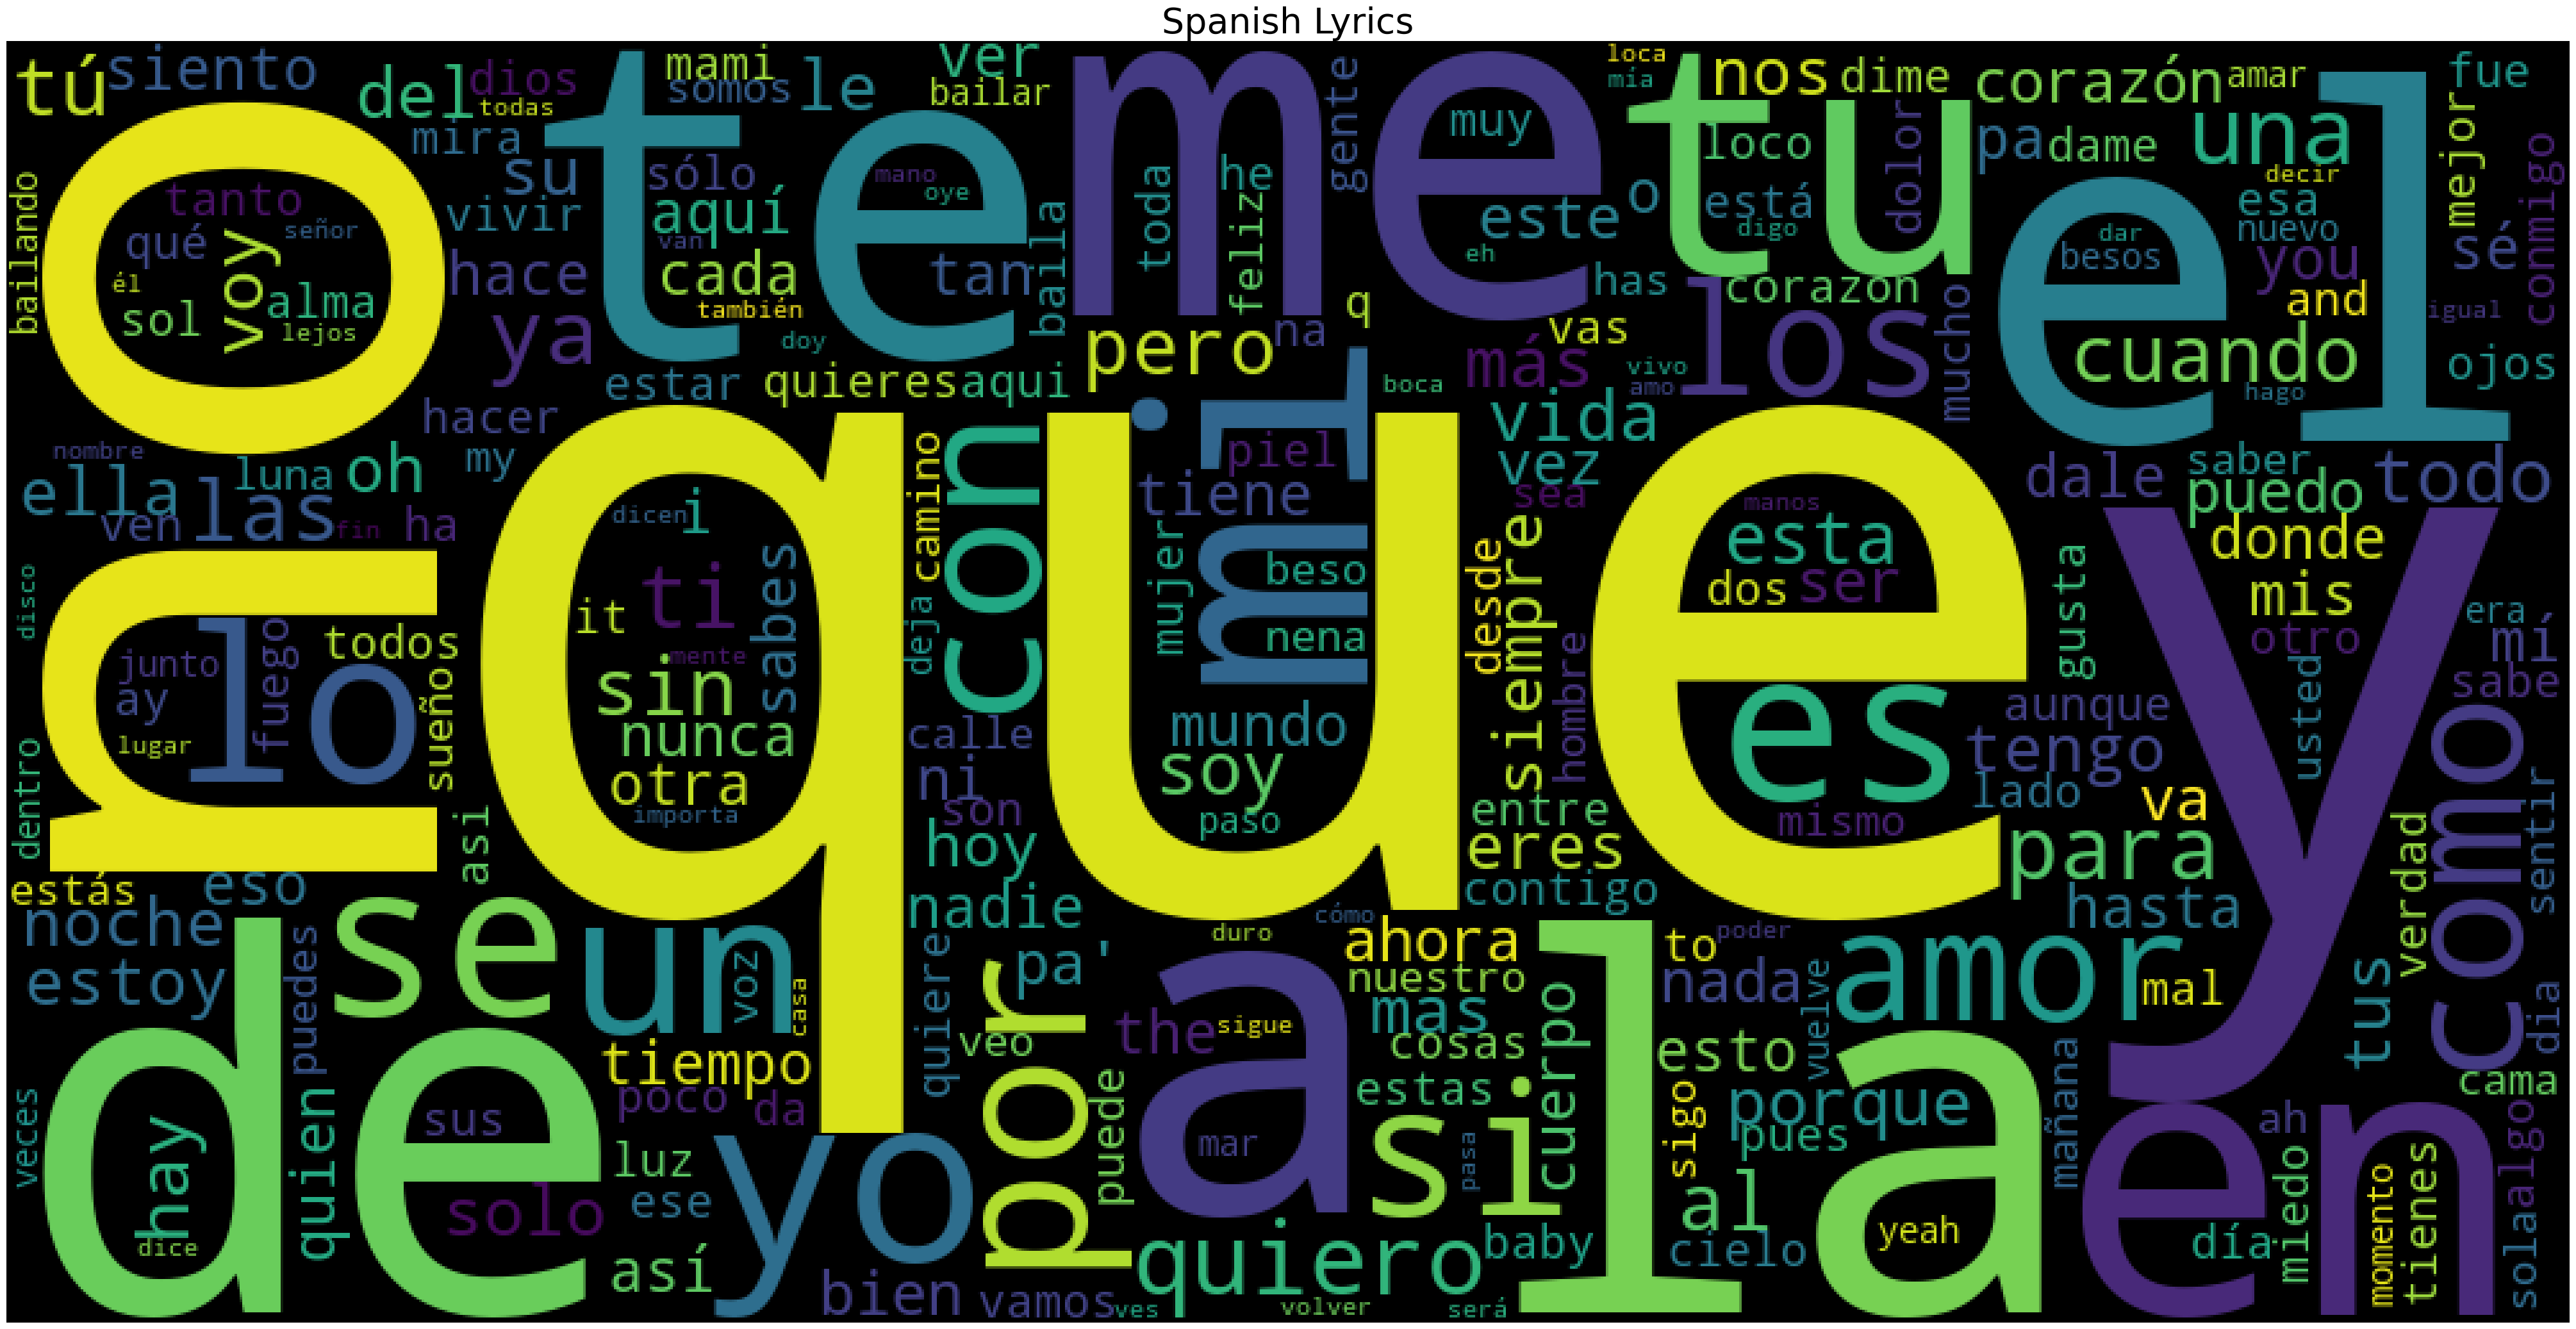

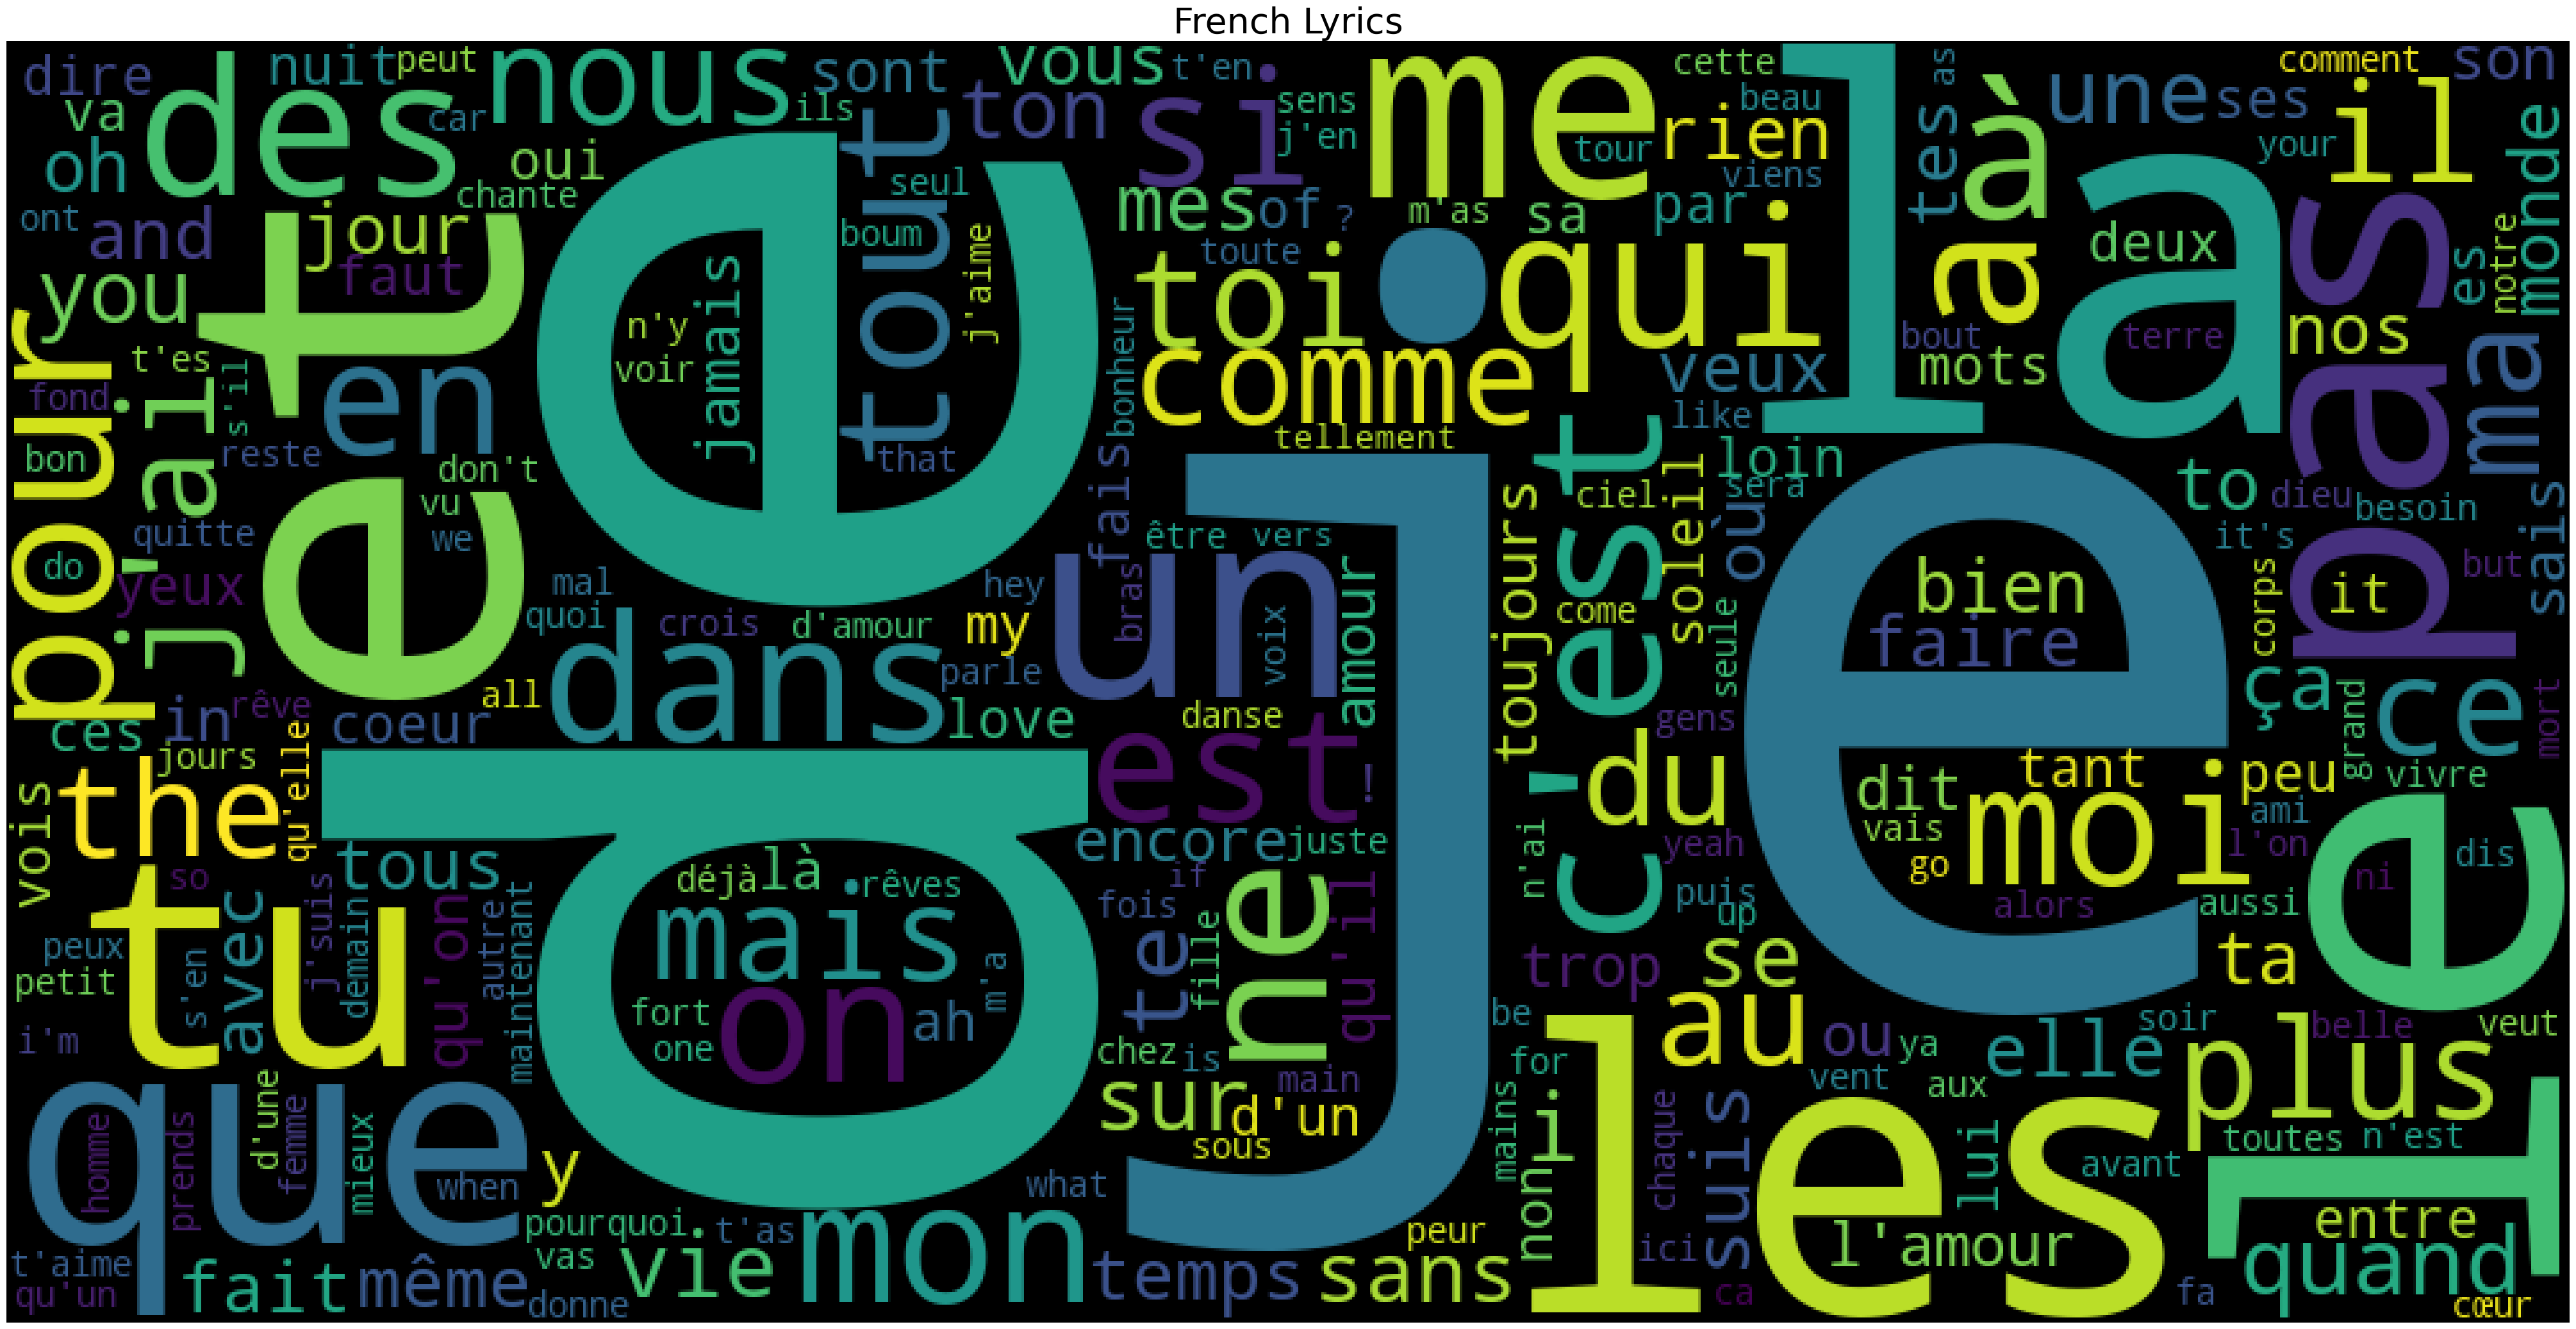

In [43]:
# Check the most common words in the lyrics per language
def common_words(text):
    # Remove unwanted characters and split into words
    cleaned_text = re.sub(r'[,\s]+', ' ', text).strip()
    words = cleaned_text.lower().split()
    
    # Count the frequency of each word
    word_freq = Counter(words)
    
    return word_freq

def WordCloudPlot(frequencies, title, max_words=250):   
    wc = WordCloud(width = 1000,height = 500,max_words = max_words).generate_from_frequencies(frequencies)
    plt.figure(figsize=(40,25))
    plt.title(title,fontsize = 40)
    plt.imshow(wc)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

# Get the most common words in the lyrics for each language
WordCloudPlot(common_words(lyrics_df[lyrics_df['language'] == 'English']['Lyric'].str.cat(sep=' ')), 'English Lyrics')
WordCloudPlot(common_words(lyrics_df[lyrics_df['language'] == 'Portuguese']['Lyric'].str.cat(sep=' ')), 'Portuguese Lyrics')
WordCloudPlot(common_words(lyrics_df[lyrics_df['language'] == 'Spanish']['Lyric'].str.cat(sep=' ')), 'Spanish Lyrics')
WordCloudPlot(common_words(lyrics_df[lyrics_df['language'] == 'French']['Lyric'].str.cat(sep=' ')), 'French Lyrics')

 Checking zipf law for the English language - by that rule, it is usually found that the most common word occurs approximately twice as often as the next common one, three times as often as the third most common, and so on.

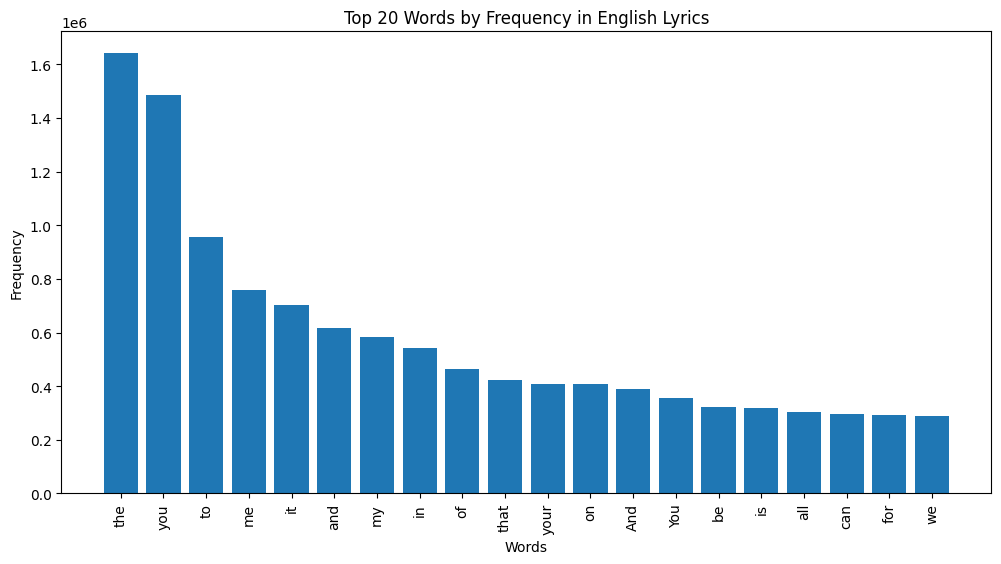

In [42]:
# Tokenize the words in the lyrics
words = tokenizer.tokenize(lyrics_df[lyrics_df['language'] == 'English']['Lyric'].str.cat(sep=' '))

#Keep onlt the words with length greater than 3
words = [word for word in words if len(word) > 1]

# Count the frequency of each word
word_freq = Counter(words)

# Sort the words by frequency
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Show it as a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(20), [freq for word, freq in sorted_word_freq[:20]])
plt.xticks(range(20), [word for word, freq in sorted_word_freq[:20]], rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Words by Frequency in English Lyrics')
plt.show()

### Let's add a new feature: lexical diversity. that will be defined by Type-Token Ratio (TTR)<br>
The TTR is the ratio of unique words (types) to the total word count (tokens) in a text. there is no need to use normalised method as the length of the songs lyrics are not so different as for texts like books / articles.

In [39]:
# Calculate the unique words count / total words count ratio
lyrics_df.loc[:, 'lexical diversity'] = lyrics_df['unique words count'] / lyrics_df['words count']

Another important feature for language learning application will be the vocabuary level and readability of the lyrics. <br> We can use the Dale-Chall readability test to calculate the readability of the *english* lyrics.

In [53]:
# Using Dale-Chall readability formula on english lyrics
lyrics_df.loc[lyrics_df['language'] == 'English', 'readability'] = lyrics_df[lyrics_df['language'] == 'English']['Lyric'].apply(textstat.dale_chall_readability_score)

In [58]:
lyrics_df[lyrics_df['language'] == 'English']['readability'].describe()

count    190856.000000
mean         11.087944
std           5.454711
min           0.150000
25%           7.230000
50%          10.100000
75%          14.010000
max          55.160000
Name: readability, dtype: float64

###  Let's add an age distriction feature using VADER lexicon for sentiment analysis and better_profanity library for profanity check

In [48]:
# nltk.download('vader_lexicon')

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def determine_age_category(lyrics, char_limit=1000):    
    # Check for profanity
    lyrics = lyrics[:char_limit]  # Only consider the first 1000 characters
    has_profanity = profanity.contains_profanity(lyrics)

    
    # Assign age category based on profanity
    if has_profanity:
        age_category = "18+"
    else:
        age_category = "All"
        
    return age_category

In [59]:
# Apply the function to the english lyrics
# lyrics_df.loc[lyrics_df['language'] == 'English', 'age category'] = lyrics_df[lyrics_df['language'] == 'English']['Lyric'].apply(determine_age_category)                                       

TODO: 
- Vocabulary Level and readabiility - examine its accuracy
- Age distriction features - try to find a way to optimize the process
- Bigram and trigram analysis: Extract common pairs (bigrams) or triplets (trigrams) of words. This can help explore common phrases or expressions in lyrics.